## Projection of Raw Data on Spherical Surface

In [4]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output



spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
file_name = "0919-f18r16ver2"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])


#=========== group ==================
#depth = (0.9, 1.7, 2.5, 3.3)
#angles = (+-30 azimuth, +-20 elevation)

# 2 5 8
# 1 4 7
# 0 3 6

#cross: 1,3,5,7
#center: 4
#oblique: 0,2,6,8

open gzip


In [33]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.shape != y.shape:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [42]:
#========= proj functions =========================================================================

%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
matplotlib.rcParams['font.family'] = "Arial"


def calc_features_by_file(file_name, save_name, ffile, sfile, PARAMS):
    """
    ffile = feature file for subject
    sfile = pointer idx file
    PARAMS = parameter file for all sub sessions
    """
    gt=[]
    hrc =[]
    eye_c=[]
    eye_l=[]
    eye_r=[]
    for fIdx in tqdm(range(144)):        
        colors = cm.rainbow(np.linspace(0, 1, 24))

        gt_pos=[]
        hrc_pos=[]
        eye_c_pos=[]
        eye_l_pos=[]
        eye_r_pos=[]       
        for sIdx in range(16):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            param = PARAMS[sIdx][pIdx]
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # Hmd = [f,4]4], Eye = [f,3,4,4], Eye1 = [f,3,4,4] combin, left, right
            # all files 144
            #print(str(sIdx), " and file distance: ", param[2])
                        
            # ----trim to end Idx------------            
            end_idx = len(trimX[pIdx])-1
            trimHmd = trimHmd[pIdx][:end_idx+1]     #ts
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]     #ts
            trimEye = trimEye[pIdx][:end_idx+1]
            trimEye1 = trimEye1[pIdx][:end_idx+1]
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            # ----separate eye file------------     
            trimEye_c = trimEye[:, 0]  #comb eye
            trimEye1_c = trimEye1[:, 0] #comb eye
            trimEye_l = trimEye[:, 1]  #comb eye
            trimEye1_l = trimEye1[:, 1] #comb eye
            trimEye_r = trimEye[:, 2]  #comb eye
            trimEye1_r = trimEye1[:, 2] #comb eye            
            
            # ----downsample OR use only last frame------------     
#             trimHmd = trimHmd[::40]  
#             trimHmd1 = trimHmd1[::40]
#             trimEye = trimEye[::40]
#             trimEye1 = trimEye1[::40]   
#             trimGTPos =trimGTPos[::40]  
#             trimY = trimY[::40]          
            
            # ----make input tensor to 3dim---(e.g [f,4,4] or [1,4,4] for single frame)
            trimHmd = trimHmd[[-1]]
            trimHmd1 = trimHmd1[[-1]]
            trimEye_c = trimEye_c[[-1]]
            trimEye1_c = trimEye1_c[[-1]]  
            trimEye_l = trimEye_l[[-1]]
            trimEye1_l = trimEye1_l[[-1]]  
            trimEye_r = trimEye_r[[-1]]
            trimEye1_r = trimEye1_r[[-1]]              
            trimGTPos =trimGTPos[[-1]]
            trimY = trimY[[-1]] 

            #----------calculate--------------------------------------
            if len(trimX[pIdx]) == 0: # if we are accessing file with 0 length, fill dummy values
                pos_gt = torch.full((20, 3), -1)
                pos_hrc = torch.full((20, 3), -1)
                pos_eye_c = torch.full((20, 3), -1)
                pos_eye_l = torch.full((20, 3), -1)
                pos_eye_r = torch.full((20, 3), -1)
            else:
                pos_gt = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT            
                pos_hrc = calc_hrc(trimHmd, trimHmd1, param) # 
                pos_eye_c = calc_erc(trimHmd, trimHmd1, trimEye_c, trimEye1_c, param)
                pos_eye_l = calc_erc(trimHmd, trimHmd1, trimEye_l, trimEye1_l, param)
                pos_eye_r = calc_erc(trimHmd, trimHmd1, trimEye_r, trimEye1_r, param)

            #-----------convert to visual field angle----------------
            #[1,3] per (file, subject) pair
            pos_gt = pos_to_param(pos_gt)
            pos_hrc = pos_to_param(pos_hrc)
            pos_eye_c = pos_to_param(pos_eye_c)
            pos_eye_l = pos_to_param(pos_eye_l)
            pos_eye_r = pos_to_param(pos_eye_r)
            
            #------------To one array tensor---------
            pos_gt = pos_gt[-1]
            pos_hrc = pos_hrc[-1]
            pos_eye_c =pos_eye_c[-1]
            pos_eye_l = pos_eye_l[-1]
            pos_eye_r =  pos_eye_r[-1]    
            
            #-----------append----------------
            gt_pos.append(pos_gt)
            hrc_pos.append(pos_hrc)
            eye_c_pos.append(pos_eye_c)
            eye_l_pos.append(pos_eye_l)
            eye_r_pos.append(pos_eye_r)             
            
        gt.append(gt_pos)
        hrc.append(hrc_pos)
        eye_c.append(eye_c_pos)
        eye_l.append(eye_l_pos)
        eye_r.append(eye_r_pos)                 
    
    #===========return dictionary===========
    print(gt[0][0][0].shape)
    data={'gt':gt, 'hrc':hrc, 'eye_c':eye_c, 'eye_l':eye_l, 'eye_r':eye_r}
    return data


#============================================================
def pos_to_param(input):   
    '''
    input: true spherical position
    output: true rectilinear param
    ''' 
    l_output = []
    for idx, pos in enumerate(input):
        x, y, z = pos[0], pos[1], pos[2]
        hor = np.arctan(-x/z) * 180 / np.pi
        ver = np.arctan(y/z) * 180 / np.pi
        dist = np.sqrt(x*x + y*y + z*z)
        param = torch.tensor([hor, ver, dist], dtype=torch.float32)
        l_output.append(param)
    l_output = torch.stack(l_output)
    return l_output     

def hmd_pos_to_hmd1_pos(GTPos, hmd_1st_tensor): # GT POS
    '''
    >TRUE SPHERICAL Y SETUP, UNITY -X SETUP
    TENSOR LIST FOR SINGLE FRAME SEQ
    input: e.g.[2200, 3], [2200, 4, 4]
    return: e.g. [2200, 3]
    '''
    l_output= []
    for frame, (gt_pos, hmd_1st) in enumerate(zip(GTPos, hmd_1st_tensor)):
        t_op = torch.eye(4)
        x,y,z = gt_pos[0], gt_pos[1], gt_pos[2]
        t_op[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)
        t_oh = hmd_1st 
        # t_hp = t_ho * t_op = inv(t_oh) * t_op
        t = torch.matmul(torch.linalg.inv(t_oh), t_op)
        l_output.append(t[:3, 3])
    l_output = torch.stack(l_output)

    return l_output

def calc_hrc(hmd, hmd1, param):
    hrc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1) in enumerate(zip(hmd, hmd1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        t_hd2 = torch.eye(4,4)
        t_hd2[2,3] = d2
        t_h1d2 = torch.matmul(t_h1h, t_hd2)
        hrc_proj_pos_tensors.append(t_h1d2[:3,3])
    hrc_proj_pos_tensors = torch.stack(hrc_proj_pos_tensors)
    return hrc_proj_pos_tensors


def calc_erc(hmd, hmd1, eye, eye1, param):
    erc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1, t_he, t_he1) in enumerate(zip(hmd, hmd1, eye, eye1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        t_h1e = torch.matmul(t_h1h, t_he)

        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        d3 = torch.norm(t_he[:3,3])
        d4 = torch.sqrt(d2*d2 - d3*d3)

        t_ed4 = torch.eye(4,4)
        t_ed4[2,3] = d4
        t_h1d4 = torch.matmul(t_h1e, t_ed4)
        erc_proj_pos_tensors.append(t_h1d4[:3,3])
    erc_proj_pos_tensors = torch.stack(erc_proj_pos_tensors)
    return erc_proj_pos_tensors

def draw_plot(data):
    """
    data: HRC[144][sub][1,3], Eye_c[144][sub][1,3], Eye_l[144][sub][1,3], Eye_r[144][sub][1,3]
    func: draw accuracy(mean) & precision(bvea) plot for depths
    """
    #=================SET PLOT================================
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
    # plt.suptitle("Projection on Spherical Visual Field", fontsize=18)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)     

    col_names = ['{}'.format(col) for col in ['D=0.9m','D=1.7m','D=2.5m','D=3.3m']]
    row_names = ['{}'.format(row) for row in ['Head Ray', 'Left Eye', 'Right Eye']]
    plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
    pad = 15 # in points

    for ax, col in zip(axes[0], col_names):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size=18, ha='center', va='baseline')

    for ax, row in zip(axes[:,0], row_names):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size=18, ha='right', va='center')

    for idx, ax in np.ndenumerate(axes):
        ax.set_xlabel('Azimuth (deg)', fontsize=15)
        ax.set_ylabel('Elevation (deg)', fontsize=15)
        ax.set_xlim(-40,40)
        ax.set_ylim(-30,30)
        ax.locator_params(nbins=5, axis='x') #xtick density

    #=================CONFIGURE DATA================================ 
    '''
    gt: list[144][16]tensor[f, 3]
    hrc: list[144][16]tensor[f, 3]
    eye_c: list[144][16]tensor[f, 3]
    eye_l: list[144][16]tensor[f, 3]
    eye_r: list[144][16]tensor[f, 3]
    '''
    gt = data['gt']
    hrc = data['hrc']
    eye_c = data['eye_c']
    eye_l = data['eye_l']
    eye_r = data['eye_r']

    #====================FILL DATA==================================
    # format to tensor [144,16,3]
    gt_tensor = torch.empty((144, 16, 3))
    hrc_tensor = torch.empty((144, 16, 3))
    eye_l_tensor = torch.empty((144, 16, 3))
    eye_r_tensor = torch.empty((144, 16, 3))
    for fidx in range(144):
        for sidx in range(16):
            gt_tensor[fidx][sidx] = gt[fidx][sidx]
            hrc_tensor[fidx][sidx] = hrc[fidx][sidx]
            eye_l_tensor[fidx][sidx] = eye_l[fidx][sidx]
            eye_r_tensor[fidx][sidx] = eye_r[fidx][sidx]
    print(gt_tensor.shape, hrc_tensor.shape, eye_l_tensor.shape)
    
    #[144,16,3] file to [4-depth, 9-target, 64-repet, 3] files
    pindices = torch.empty(36)
    for fidx in range(36): #4 repetition
        remainder = fidx // 4
        floor = fidx % 4
        pointer_idx = floor * 9 + remainder
        pindices[fidx]=pointer_idx
    pindices =torch.tensor(pindices, dtype=torch.int32)
    
    # pre-reshape => align target numbering => finish reshape
    gt_tensor = torch.reshape(gt_tensor, (4,36,16,3))    
    hrc_tensor = torch.reshape(hrc_tensor, (4,36,16,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,36,16,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,36,16,3))    
    gt_tensor = gt_tensor[:, pindices] 
    hrc_tensor = hrc_tensor[:, pindices] 
    eye_l_tensor = eye_l_tensor[:, pindices] 
    eye_r_tensor = eye_r_tensor[:, pindices]      
    gt_tensor = torch.reshape(gt_tensor, (4,9,64,3))    
    hrc_tensor = torch.reshape(hrc_tensor, (4,9,64,3))
    eye_l_tensor = torch.reshape(eye_l_tensor, (4,9,64,3))
    eye_r_tensor = torch.reshape(eye_r_tensor, (4,9,64,3))        
    
    #====================PLOT DATA==================================
    for didx, (ax, gt, data) in enumerate(zip(axes[0], gt_tensor, hrc_tensor)):        
        for pidx in range(9):
            x_gt = np.array(gt[pidx, :, 0])
            y_gt = np.array(gt[pidx, :, 1])
            x=np.array(data[pidx, :, 0])
            y=np.array(data[pidx, :, 1])
            ax.scatter(x_gt, y_gt, s=0.5)            
            ax.scatter(x, y, s=0.5)            
            confidence_ellipse(x, y, ax, n_std=1, edgecolor='red')
        
        
    for ax, data in zip(axes[1], eye_l_tensor):
        for pidx in range(9):
            x_gt = np.array(gt[pidx, :, 0])
            y_gt = np.array(gt[pidx, :, 1])
            x=np.array(data[pidx, :, 0])
            y=np.array(data[pidx, :, 1])
            ax.scatter(x_gt, y_gt, s=0.5)            
            ax.scatter(x, y, s=0.5)            
            confidence_ellipse(x, y, ax, n_std=1, edgecolor='red')        
     
    for ax, data in zip(axes[2], eye_r_tensor): 
        for pidx in range(9):
            x_gt = np.array(gt[pidx, :, 0])
            y_gt = np.array(gt[pidx, :, 1])
            x=np.array(data[pidx, :, 0])
            y=np.array(data[pidx, :, 1])
            ax.scatter(x_gt, y_gt, s=0.5)            
            ax.scatter(x, y, s=0.5)            
            confidence_ellipse(x, y, ax, n_std=1, edgecolor='red')         
        
        
#     fig.tight_layout()
#     plt.show()


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 55.34it/s]
C:\Users\thecascade-pc1\AppData\Local\Temp\ipykernel_19084\3397201610.py:269: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pindices =torch.tensor(pindices, dtype=torch.int32)


torch.Size([])
torch.Size([144, 16, 3]) torch.Size([144, 16, 3]) torch.Size([144, 16, 3])


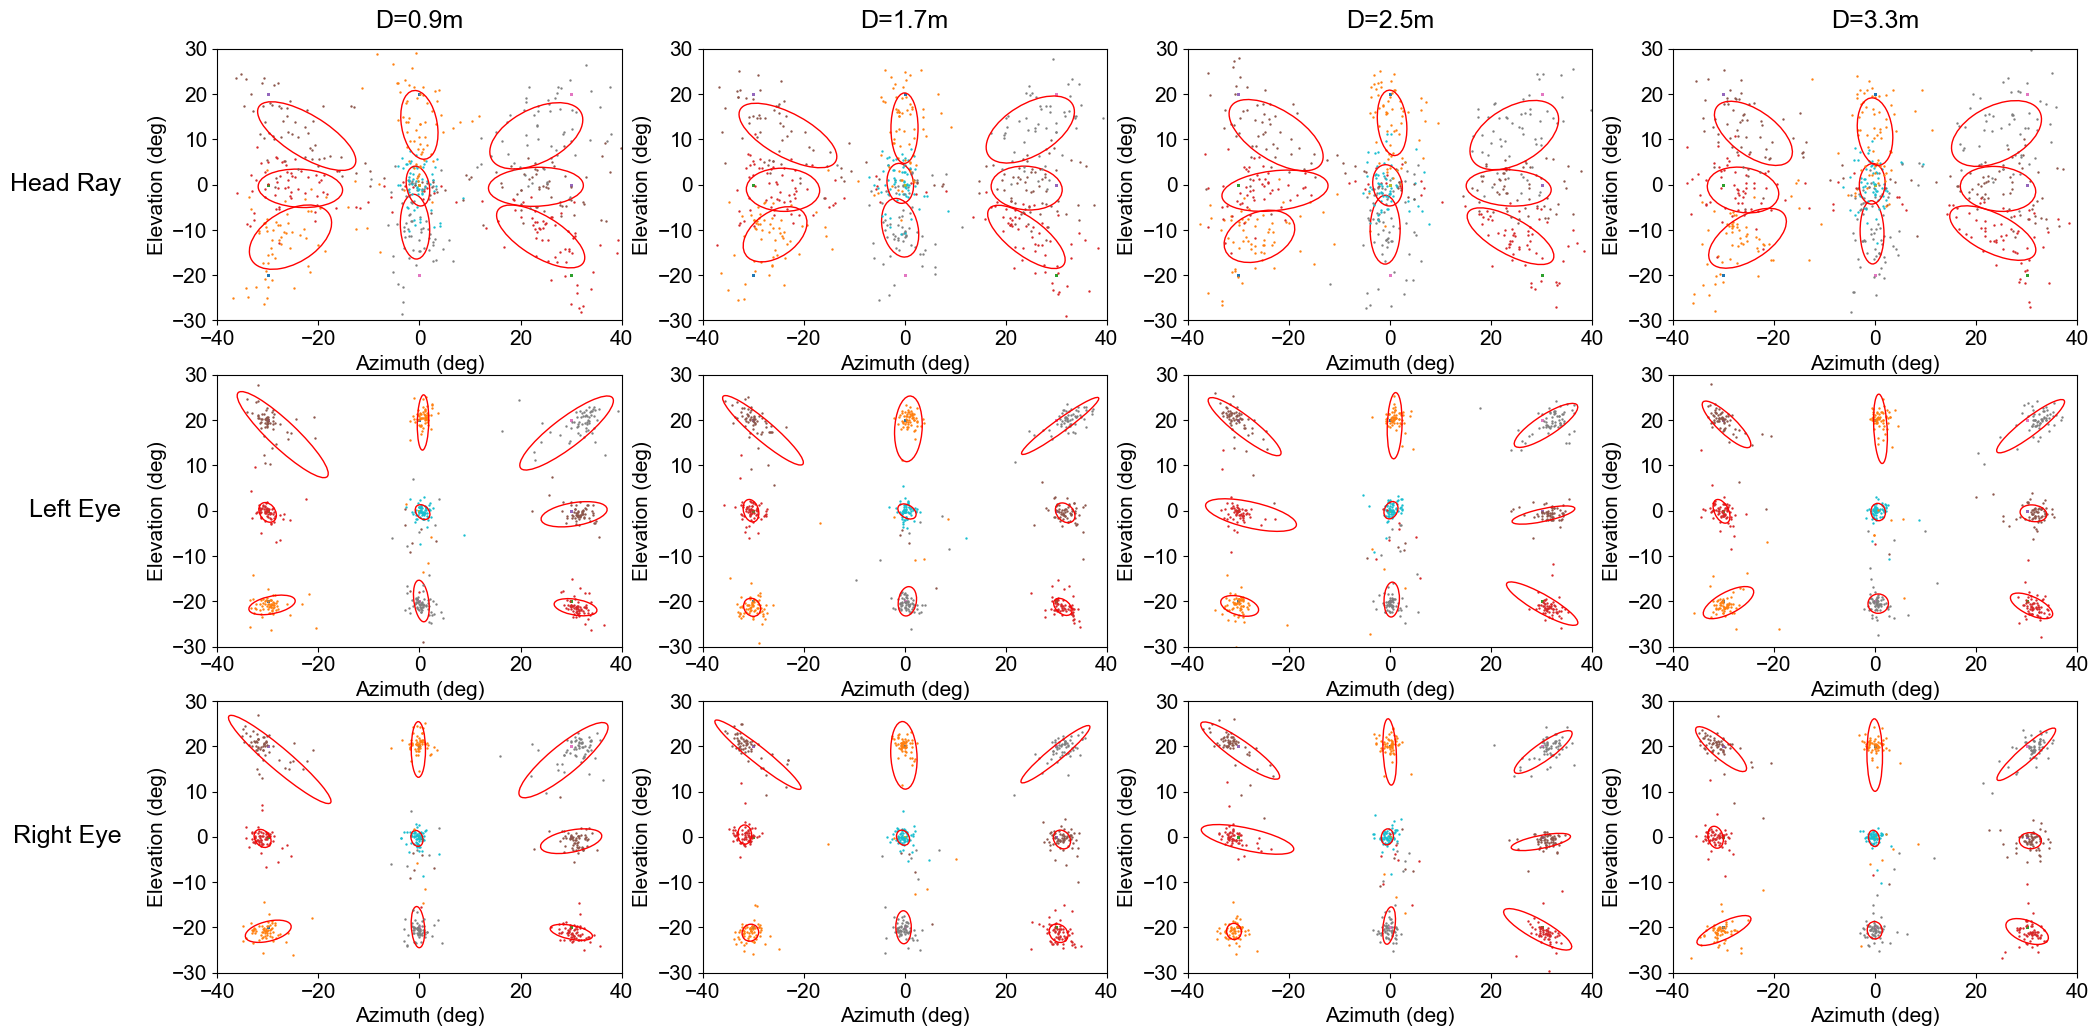

In [43]:
# draw_features_by_file(file_name, save_name, ffile, sfile)
data= calc_features_by_file(file_name, "testtest", ffile, sfile, PARAMS)
draw_plot(data)

In [3]:
# #========= proj functions =========================================================================

# %matplotlib notebook
# %matplotlib inline
# from tqdm import tqdm
# from functools import partial
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# from matplotlib import rc
# import matplotlib.cm as cm
# from matplotlib.collections import LineCollection

# def draw_features_by_file(file_name, save_name, ffile, sfile, PARAMS):
#     """
#     ffile = feature file for subject
#     sfile = pointer idx file
#     PARAMS = parameter file for all sub sessions
#     """
#     # GT position is not showing the pattern
#     fig, (ax) = plt.subplots(1,1)
#     fig.set_size_inches(8,8)
#     plt.title("All")
#     for fIdx in tqdm(range(144)):        
#         colors = cm.rainbow(np.linspace(0, 1, 24))
#         # fig, (ax) = plt.subplots(1,1)
#         # fig.set_size_inches(8,8)
#         # plt.title('file_num: '+str(fIdx+1)+ "/144")

#         for sIdx in range(16):
#             pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#             param = PARAMS[sIdx][pIdx]
#             trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
#             # print("trimEye, trimEye1", trimHmd[0].shape, trimEye[0].shape, trimEye1[0].shape)
#             # print("trimHmd, trimEye, trimEye1", len(trimHmd), len(trimEye), len(trimEye1))
#             # print(str(sIdx), " and file distance: ", param[2])

#             # ----trim to end Idx------------            
#             end_idx = len(trimX[pIdx])-1
#             trimHmd = trimHmd[pIdx][:end_idx+1]     #ts
#             trimHmd1 = trimHmd1[pIdx][:end_idx+1]     #ts
#             trimEye = trimEye[pIdx][:end_idx+1, 0]  #comb eye
#             trimEye1 = trimEye1[pIdx][:end_idx+1, 0] #comb eye
#             trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
#             trimY = trimY[pIdx][:end_idx+1]         #rel_params

#             # ----downsample OR use only last frame------------     
# #             trimHmd = trimHmd[::40]  
# #             trimHmd1 = trimHmd1[::40]
# #             trimEye = trimEye[::40]
# #             trimEye1 = trimEye1[::40]   
# #             trimGTPos =trimGTPos[::40]  
# #             trimY = trimY[::40]          
            
#             trimHmd = trimHmd[[-1]] #use double bracket to retain dimension in 1-element slicing
#             trimHmd1 = trimHmd1[[-1]]
#             trimEye = trimEye[[-1]]
#             trimEye1 = trimEye1[[-1]]  
#             trimGTPos =trimGTPos[[-1]]
#             trimY = trimY[[-1]] 

#             #----------plot--------------------------------------
#             if len(trimX[pIdx]) == 0: # if we are accessing file with 0 length, fill dummy values
#                 pos0 = torch.full((20, 3), -1)
#                 pos1 = torch.full((20, 3), -1)
#                 pos_eye_c = torch.full((20, 3), -1)
#                 pos_eye_left = torch.full((20, 3), -1)
#                 pos_eye_right = torch.full((20, 3), -1)
#             else:
#                 pos0 = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT            
#                 pos1 = calc_hrc(trimHmd, trimHmd1, param) # 
#                 pos_eye_c = calc_erc(trimHmd, trimHmd1, trimEye, trimEye1, param)


#             # pos0 = pos_to_param(pos0)
#             # pos1 = pos_to_param(pos1)
#             # pos_eye_c = pos_to_param(pos_eye_c)

#             x0, y0 = pos0[:,0], pos0[:,1]
#             x1, y1 = pos1[:,0], pos1[:,1]
#             x_c, y_c = pos_eye_c[:,0], pos_eye_c[:,1]

#             color = np.array([colors[sIdx]])
#             ax.scatter(x0, y0, c='r', marker='d', label='gts', alpha=0.2)
#             ax.scatter(x1, y1, c='g', marker='+', label='HRC', alpha=0.2)            
#             ax.scatter(x_c, y_c, c='b', marker='.', label='ERC_comb', alpha=0.2)
#             # ax.scatter(x1[-1], y1[-1], c='r', marker='s', alpha=1)

#             pos1_text = 's' + str(sIdx+1) 
#             # ax.text(x1[-1], y1[-1], pos1_text)
#             ax.set_xlabel('X (meter)')
#             ax.set_ylabel('Y (meter)')            
#             # ax.set_xlabel('H (degree)')
#             # ax.set_ylabel('V (degree)')
            
#             if sIdx == 0 and fIdx==0:
#                 plt.legend()
#         plt.xlim([-45,45])
#         plt.ylim([-45,45])
#         plt.xlim([-2,2])
#         plt.ylim([-2,2])

#         plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)        

#         # savename = "f" + str(fIdx+1)
#         # fig.savefig(savename)
#         #plt.show()        # plt.legend()
#     savename = "all 144 files for 16 subjects"
#     fig.savefig(savename)

tensor([[[0.3742, 0.6304, 0.8262, 0.3118],
         [0.9561, 0.6929, 0.1964, 0.9649],
         [0.1826, 0.2678, 0.6304, 0.0057]],

        [[0.8312, 0.6199, 0.0615, 0.9140],
         [0.1898, 0.1500, 0.3005, 0.8754],
         [0.1749, 0.3359, 0.7567, 0.6952]]])
tensor([[[0.1826, 0.2678, 0.6304, 0.0057],
         [0.9561, 0.6929, 0.1964, 0.9649],
         [0.3742, 0.6304, 0.8262, 0.3118]],

        [[0.1749, 0.3359, 0.7567, 0.6952],
         [0.1898, 0.1500, 0.3005, 0.8754],
         [0.8312, 0.6199, 0.0615, 0.9140]]])
